In [314]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
from tqdm import tqdm
%matplotlib inline

In [315]:
with open('data/combined_english_names_cleaned.txt','r') as f:
# with open('data/combined_arabic_names_cleaned.txt','r') as f:

    names = [x.strip().lower() for x in f.readlines()]
names[:10]

['abdelrahman',
 'albiloni',
 'wsamaiah',
 'sammar',
 'alrshidiah',
 'jllai',
 'aljroshi',
 'hazizah',
 'noshin',
 'akhdan']

In [316]:
chars = ['.'] + sorted(list(set(''.join(names))))
stoi = { c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}
print(stoi)
print(itos)
print( sorted(list(set(''.join(names)))))

{'.': 0, '-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'y': 25, 'z': 26}
{0: '.', 1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'y', 26: 'z'}
['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']


In [317]:
def build_dataset(names, context_size, p=False):
    X = []
    Y = []

    for name in names:

        if p :
            print(name)
        context = [stoi['.']] * context_size

        for c in name + '.':
            X.append(context)
            Y.append(stoi[c])

            if p:
                print( ''.join(itos[x] for x in context) ,f' --> {c}')

            context = context[1:] + [stoi[c]]

    
    X = torch.tensor(X)
    Y = torch.tensor(Y)


    return X,Y

In [318]:
## MLP Setup

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
CONTEXT_SIZE = 8
VOCAB_SIZE = len(chars)
EPS  = 1e-5

In [319]:
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
x_train, y_train = build_dataset( names[:n1], CONTEXT_SIZE )
x_val, y_val = build_dataset( names[n1:n2], CONTEXT_SIZE )
x_test, y_test = build_dataset( names[n2:], CONTEXT_SIZE )

In [320]:
class Linear():
    def __init__(self, in_n, out_n, bias=True) -> None:
        self.params = []
        self.have_bias = bias
        self.weight = torch.randn((in_n,out_n)) / (in_n**0.5)
        self.params.append(self.weight)

        self.bias = None
        if self.have_bias:
            self.bias = torch.zeros(out_n)
            self.params.append(self.bias)
    
    def __call__(self,x, is_training =True):
        self.is_training = is_training

        self.out = x @ self.params[0]
        if self.have_bias:
            self.out += self.params[1]
        return self.out

    def set_parameters(self,p):
        self.params = p
        # self.weight = p[0]
        # self.bias = p[1]
        # self.params = [p]

    def parameters(self):
        return self.params
        

In [321]:
class BatchNorm():
    def __init__(self, in_n,eps=1e-5, momentum = 0.1) -> None:
        self.eps = eps
        self.is_training = True
        self.momentum = momentum
        self.running_mean = torch.zeros(in_n)
        self.running_std  = torch.ones(in_n)
        self.gain = torch.ones(in_n)
        self.bias = torch.zeros(in_n)
        self.params = [self.gain , self.bias]


    def __call__(self, x,  is_training= True):

        self.is_training = is_training
        if self.is_training:

            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)

            mean = x.mean(dim,keepdims= True)
            ## unbiased??
            std = x.std(dim,keepdims= True)


            self.out =  self.params[0] * (x - mean / (std + self.eps**0.5)) + self.params[1]

            with torch.no_grad():
                self.running_mean = self.running_mean * (1- self.momentum) \
                    + self.momentum * mean
                self.running_std = self.running_std * (1- self.momentum) \
                + self.momentum * std

        else:
            # print(self.running_mean , self.running_std)
            self.out =  self.params[0] * (x - self.running_mean / (self.running_std + self.eps**0.5)) + self.params[1]



        return self.out

    def set_parameters(self,p):
        self.params = p
        # self.gain = p[0]
        # self.bias = p[1]
        # self.params = [self.gain , self.bias]
    def set_mean_std(self, conf):
        self.running_mean = conf[0]
        self.running_std = conf[1]
    def get_mean_std(self):
        return [self.running_mean, self.running_std]

    def parameters(self):
        return self.params


In [322]:
class Activation():
    def __init__(self, activation='tanh'):
        self.params = []
        if activation == 'tanh':
            self.forward = self._forward_tanh
        elif activation == 'relu':
            self.forward = self._forward_relu
        else:
            raise Exception('Only tanh, and relu activations are supported')

    def _forward_relu(self,x):
        return torch.relu(x)
    def _forward_tanh(self,x):
        return torch.tanh(x)

    def __call__(self, x, is_training= True):

        self.is_training = is_training

        
        self.out = self.forward(x)
        return self.out
    
    def set_parameters(self,p):
        self.params = p
    def parameters(self):
        return self.params

In [323]:
class Embedding:
    def __init__(self, n_in, n_out) -> None:
        self.weight = torch.randn((n_in,n_out))

    def __call__(self, indicies, is_training=True):


        self.out = self.weight[indicies]
        
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x,is_training=True) :
            a =x.view(x.shape[0],-1)
             

            self.out = a
            
            return a
    def parameters(self):
        return []

class SoftFlatten:
    def __init__(self,n):
         self.n = n

    def __call__(self, x,is_training=True) :
            
            a =x.view(x.shape[0],-1,x.shape[2] * self.n)
            if a.shape[1] == 1:
                 a = a.squeeze(1)
             

            self.out = a
            
            return a
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x ,is_training=True):
        for l in self.layers:
            x = l(x, is_training)
            self.out = x
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [324]:
x = torch.tensor([[1,2],[3,4],[5,6],[7,8]])

a = x[::2,:]
b = x[1::2,:]
print(a)
print(b)


print(torch.concat([a,b ] ,dim = 1))
print(x.view(2,4))

print(SoftFlatten(2)(x.unsqueeze(0)))


tensor([[1, 2],
        [5, 6]])
tensor([[3, 4],
        [7, 8]])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
tensor([[[1, 2, 3, 4],
         [5, 6, 7, 8]]])


In [325]:


## SETUP
n_embed = 32
n_hidden = 200
activation = 'relu'
embedding = torch.randn((VOCAB_SIZE,n_embed))

layers = [
    
    Embedding(VOCAB_SIZE, n_embed),
    SoftFlatten(2),Linear(2*n_embed , n_hidden, bias=False) ,BatchNorm(n_hidden), Activation(activation),
    SoftFlatten(2),Linear(2*n_hidden , n_hidden, bias=False),BatchNorm(n_hidden), Activation(activation),
    SoftFlatten(2),Linear(2*n_hidden , n_hidden, bias=False),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden , VOCAB_SIZE)
]

model = Sequential(layers)

parameters = model.parameters()

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

180291


In [326]:
def forward(x_batch, is_training):
    # # x_batch = embedding[x_batch]
    # x = x_batch.view(x_batch.shape[0], -1)
    x = x_batch
    for layer in layers:
        x = layer(x, is_training)
    return x

In [327]:
STEPS = 2_000_00
BATCH_SIZE = 128
lossi = []

for i in tqdm(range(STEPS)):
    indices = torch.randint(0, x_train.shape[0],(BATCH_SIZE,))
    x_batch , y_batch = x_train[indices], y_train[indices]

    
    x = model(x_batch)

    loss = F.cross_entropy(x,y_batch)

    ################### BACKWARD ##################
    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.001 if i < STEPS*0.7 else 0.0001
    with torch.no_grad():
        for p in parameters:
            p += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{STEPS:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000: 3.4606


  5%|▌         | 10049/200000 [00:38<11:50, 267.42it/s]

  10000/ 200000: 2.1787


 10%|█         | 20050/200000 [01:17<11:23, 263.34it/s]

  20000/ 200000: 1.9373


 15%|█▌        | 30038/200000 [01:55<10:33, 268.43it/s]

  30000/ 200000: 1.9242


 20%|██        | 40034/200000 [02:33<10:15, 259.86it/s]

  40000/ 200000: 1.9568


 25%|██▌       | 50038/200000 [03:11<09:33, 261.61it/s]

  50000/ 200000: 1.6787


 30%|███       | 60043/200000 [03:49<09:03, 257.73it/s]

  60000/ 200000: 1.7935


 35%|███▌      | 70028/200000 [04:27<08:22, 258.60it/s]

  70000/ 200000: 1.9080


 40%|████      | 80048/200000 [05:06<09:15, 215.86it/s]

  80000/ 200000: 2.0180


 45%|████▌     | 90047/200000 [05:44<05:46, 317.58it/s]

  90000/ 200000: 1.9388


 50%|█████     | 100057/200000 [06:18<05:45, 289.38it/s]

 100000/ 200000: 2.0090


 55%|█████▌    | 110053/200000 [06:53<04:50, 309.99it/s]

 110000/ 200000: 1.7607


 60%|██████    | 120064/200000 [07:28<04:11, 317.67it/s]

 120000/ 200000: 1.6562


 65%|██████▌   | 130056/200000 [08:03<03:55, 296.91it/s]

 130000/ 200000: 1.9968


 70%|███████   | 140034/200000 [08:38<03:38, 274.52it/s]

 140000/ 200000: 2.1849


 75%|███████▌  | 150040/200000 [09:13<03:02, 274.03it/s]

 150000/ 200000: 1.9290


 80%|████████  | 160051/200000 [09:48<02:20, 285.29it/s]

 160000/ 200000: 1.8802


 85%|████████▌ | 170057/200000 [10:23<01:33, 320.43it/s]

 170000/ 200000: 1.7749


 90%|█████████ | 180036/200000 [10:57<01:07, 295.43it/s]

 180000/ 200000: 1.8094


 95%|█████████▌| 190064/200000 [11:31<00:32, 307.07it/s]

 190000/ 200000: 1.8355


100%|██████████| 200000/200000 [12:06<00:00, 275.21it/s]


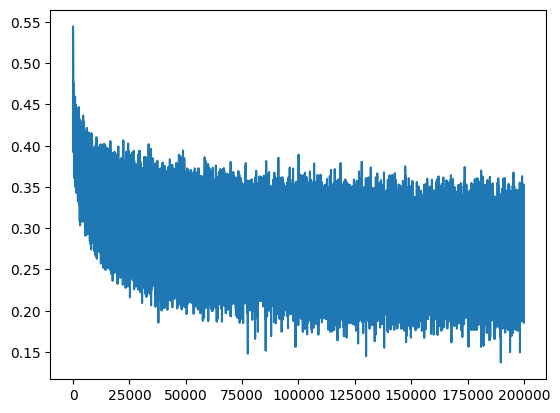

In [328]:
plt.plot(lossi)

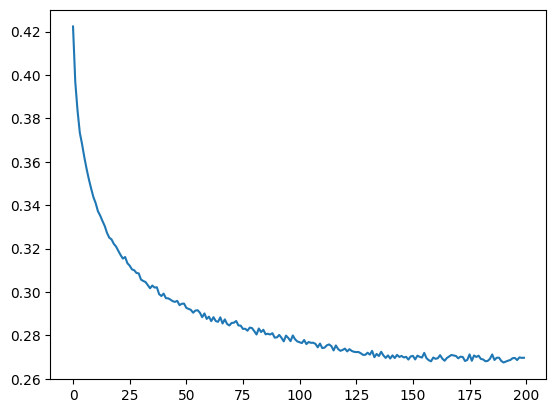

In [329]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [330]:
for layer in layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))


Embedding : (128, 8, 32)
SoftFlatten : (128, 4, 64)
Linear : (128, 4, 200)
BatchNorm : (128, 4, 200)
Activation : (128, 4, 200)
SoftFlatten : (128, 2, 400)
Linear : (128, 2, 200)
BatchNorm : (128, 2, 200)
Activation : (128, 2, 200)
SoftFlatten : (128, 400)
Linear : (128, 200)
BatchNorm : (128, 200)
Activation : (128, 200)
Linear : (128, 27)


In [331]:
@torch.no_grad()
def eval(split):

    x,y = {

        'train' : (x_train, y_train),
        'val' : (x_val, y_val),
        'test' : (x_test, y_test),
    }[split]
    x = model(x, False) 
    loss = F.cross_entropy(x,y)


    print(split, loss.item())
    

In [332]:
for layer in layers:
    layer.training = False


eval('train')
eval('val')
eval('test')


train 1.8523900508880615
val 1.8707696199417114
test 1.8652713298797607


In [333]:
def generate_name():

    # embedding,w1,b1,w2,b2,bnbias,bngain = best_params 
    w = ''
    last_ch = [0]* CONTEXT_SIZE
    while True:
        last_ch = torch.tensor(last_ch).unsqueeze(0)
        x = forward(last_ch,False)
        last_ch = last_ch.clone().detach().squeeze(0)

        p = torch.softmax(x, dim=1)

        next_ch = torch.multinomial(p, num_samples=1, replacement=True).item()

        last_ch = last_ch.tolist()
        last_ch = last_ch[1:] + [next_ch]

        w += itos[next_ch]

        if next_ch == 0:
            break

    return w

In [334]:
for i in range(10):
   print(generate_name())

alkararahit.
rhaiman.
dhwaat.
mntad.
altnaiab.
aoilah.
alrnanaz.
hamadiah.
ghabqur.
jhhazai.


In [335]:
## saving weights

# parameters = [embedding] + [layer.parameters() for layer in layers ]

# bn_conf = []
# for l in layers:
#     if l.__class__.__name__ == "BatchNorm":
#         bn_conf.append(l.get_mean_std())

# save_dict = {
#     'params': parameters,
#     'bn_conf': bn_conf
# }

# torch.save(save_dict,'weights/en_dataset_weights.pt')